In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
%matplotlib inline


In [8]:
dataset = pd.read_csv('car_price_data.csv')

In [9]:
#understand the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

In [10]:
#checking for missing values
dataset.isnull().sum()

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64

In [11]:
#column names & string values: lowercasing everything and
#replace spaces with underscores
dataset.columns = dataset.columns.str.lower().str.replace(' ', '_')
string_columns = list(dataset.dtypes[dataset.dtypes == 'object'].index)

for col in string_columns:
    dataset[col] = dataset[col].str.lower().str.replace(' ', '_')

In [17]:
#get rid of missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
imputer.fit(dataset[['engine_cylinders']])
#transform method will replace nan values with most frequent values
dataset['engine_cylinders'] = imputer.transform(dataset[['engine_cylinders']])

#replace missing values of Engine HP with mean
imputer_01 = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer_01.fit(dataset[['engine_hp']])
#transform method will replace nan values with mean values
dataset['engine_hp'] = imputer_01.transform(dataset[['engine_hp']])

#replace missing values of Engine Fuel Type with most frequent value
imputer.fit(dataset[['engine_fuel_type']])
#transform method will replace nan values with most frequent values
dataset['engine_fuel_type'] = imputer.transform(dataset[['engine_fuel_type']])

#replace missing values of Number of Doors with most frequent value
imputer.fit(dataset[['number_of_doors']])
#transform method will replace nan values with most frequent values
dataset['number_of_doors'] = imputer.transform(dataset[['number_of_doors']])

#replace missing values of Market Category with string 'None'
imputer_02 = SimpleImputer(missing_values = np.nan, strategy = 'constant')
imputer_02.fit(dataset[['market_category']])
#transform method will replace nan values with most frequent values
dataset['market_category'] = imputer_02.transform(dataset[['market_category']])

In [18]:
#choose categorical variables
categorical = ['make', 'model', 'engine_fuel_type', 'transmission_type', 'driven_wheels', 'market_category', 
              'vehicle_size', 'vehicle_style']

In [19]:
#see how strong is the influence of Market Category on Target variable
#if not too high, I would replace the missing values with 'most_frequent'
#use mutual information
from sklearn.metrics import mutual_info_score

#calculation of mutual information
def calculate_mi(series):
    return mutual_info_score(series, dataset.msrp)

df_mi = dataset[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

,MI
model,5.431899
make,2.675117
market_category,2.225667
vehicle_style,1.640058
engine_fuel_type,0.936463
driven_wheels,0.914208
vehicle_size,0.724415
transmission_type,0.557783


In [20]:
#if I replace Market Category with strategy = 'constant', I would get an mi of 2.22
#if I replace Market Category with strategy = 'most_frequent', I would get an mi of 2.05
#I would take constant, because I cannot guess what is behind the missing values

In [21]:
#check if there are any other missing values
dataset.isnull().sum()

make                 0
model                0
year                 0
engine_fuel_type     0
engine_hp            0
engine_cylinders     0
transmission_type    0
driven_wheels        0
number_of_doors      0
market_category      0
vehicle_size         0
vehicle_style        0
highway_mpg          0
city_mpg             0
popularity           0
msrp                 0
dtype: int64

In [22]:
#split dataset in training and test set
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(dataset, test_size = 0.2, random_state = 1)

In [23]:
#calculate logarithm of target variable
#because distribution of target variable has a 'long tail'
#here we already create a matrix array with the target variable
y_train = np.log1p(df_train.msrp.values)
y_test = np.log1p(df_test.msrp.values)

#delete dependent variable
del df_train['msrp']
del df_test['msrp']

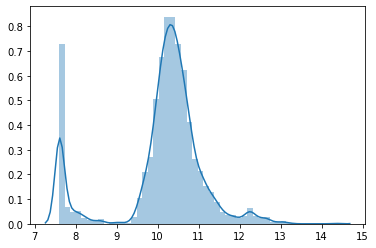

In [24]:
#check value distribution of target variable
sns.distplot(y_test)


In [25]:
#define first numerical features
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

In [26]:
#train multiple linear regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(df_train[base], y_train)

LinearRegression()

In [27]:
#use model (regressor) to predict target variable
y_pred = regressor.predict(df_test[base])

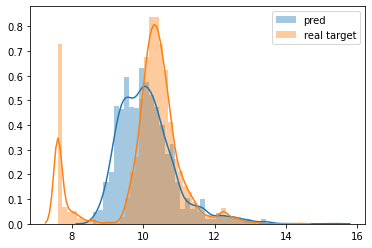

In [28]:
#plot shows difference between distribution of real target variable
#and predicted target variable (based on test set)
sns.distplot(y_pred, label = 'pred')
sns.distplot(y_test, label = 'real target')
plt.legend()

In [29]:
#calculate root mean squared error
#based difference between distribution of real target variable
#and predicted target variable 
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)
rmse(y_test, y_pred)


0.7281492411053084

In [30]:
#use prepare_X function to add 'age' feature to training and testing set
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    df['age'] = 2017 - df.year
    features.append('age')
    df_num = df[features]
    return df_num

In [31]:
#can the added feature 'age' improve the model?

X_train = prepare_X(df_train)
#train the model
regressor.fit(X_train, y_train)

LinearRegression()

In [32]:
#apply model to test set
X_test = prepare_X(df_test)
y_pred = regressor.predict(X_test)

#comute RMSE on test set
print('validation:', rmse(y_test, y_pred))

validation: 0.49436076818495245


In [33]:
#use prepare_X function to add 'age' feature and categ features to training and testing set
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    df['age'] = 2017 - df.year
    features.append('age')
    features.append('number_of_doors')
    df_num = df[features]
    return df_num

In [34]:
X_train = prepare_X(df_train)
#train the model
regressor.fit(X_train, y_train)

#apply model to test set
X_test = prepare_X(df_test)
y_pred = regressor.predict(X_test)

#compute RMSE on test set
print('testing:', rmse(y_test, y_pred))

testing: 0.4943636627761644


In [35]:
#use prepare_X function to add 'age' feature and more categ features to training and testing set
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    df['age'] = 2017 - df.year
    features.append('age')
    features.append('number_of_doors')
    features.append('make')
    features.append('model')
        
    df_num_cat = pd.get_dummies(df[features])
    return df_num_cat

In [36]:
#get dataset matrices
X_train = prepare_X(df_train)
X_test = prepare_X(df_test)

In [37]:
#get difference between column length of two matrices
list_train = list(X_train)
len(list_train)
list_test = list(X_test)
len(list_test)
len_diff_list = len(list_train) - len(list_test)
len_diff_list

222

In [38]:
#add missing features by adding columns, where the values are 0
def add_columns(df):
    X_test
    for n in range(len_diff_list):
        X_test[n] = 0
    X = X_test.values
    return X
    

In [39]:
#test if there is an output of the add_columns function
add_columns(X_test)

array([[400.,   6.,  39., ...,   0.,   0.,   0.],
       [420.,   8.,  21., ...,   0.,   0.,   0.],
       [311.,   6.,  29., ...,   0.,   0.,   0.],
       ...,
       [274.,   4.,  31., ...,   0.,   0.,   0.],
       [700.,  12.,  16., ...,   0.,   0.,   0.],
       [ 99.,   4.,  46., ...,   0.,   0.,   0.]])

In [40]:
#train the model
regressor.fit(X_train, y_train)



LinearRegression()

In [41]:
#apply model to test set
X_test = prepare_X(df_test)
X_test_complete = add_columns(X_test)


In [42]:
y_pred = regressor.predict(X_test_complete)

#compute RMSE on test set
print('testing:', rmse(y_test, y_pred))

testing: 7360108.353783034


In [43]:
#Evaluating Model Performance with R Squared
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

-46322340572101.39

In [45]:
#the performance is quiet bad, we can try to apply
#regularization, that helps us to control the model
#and avoid that the weights grow too much
from sklearn.linear_model import Ridge
X_train = prepare_X(df_train)
clf = Ridge(alpha = 1.0)
clf.fit(X_train, y_train)

#apply model to test set
X_test = prepare_X(df_test)
X_test_complete = add_columns(X_test)
y_pred = clf.predict(X_test_complete)

#compute RMSE on validation dataset
print('testing:', rmse(y_test, y_pred))

testing: 0.6188549693464026


In [46]:
#Evaluating Model Performance with R Squared
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.672508641617114